In [2]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25


# look at gv reults

In [60]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/fusion/124_patients/transcriptome_fusion_files.txt'
df1 = pd.read_csv(f1, header=None)
df1.head(2)

df1[1] = df1[0].apply(lambda x:x.split('/')[5])
df1.columns = ['fusion_file', 'pat']
df1.head(2)

,fusion_file,pat
0,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,HTMCP-03-06-02001
1,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,HTMCP-03-06-02216


In [61]:
f2= '/projects/trans_scratch/validations/workspace/szong/Cervical/fusion/124_patients/transcriptome_indel_files.txt'
df2= pd.read_csv(f2, header=None)
df2.head(2)

df2[1] = df2[0].apply(lambda x:x.split('/')[5])
df2.columns = ['indel_file', 'pat']
df2.head(2)

,indel_file,pat
0,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,HTMCP-03-06-02001
1,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,HTMCP-03-06-02216


In [62]:
dfm = pd.merge(df1, df2, left_on='pat', right_on='pat', how='outer').set_index('pat')

In [63]:
dfm.head(2)

,fusion_file,indel_file
pat,,
HTMCP-03-06-02001,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,/projects/NCI_validation2_assembly/NCI_SAIC_HI...
HTMCP-03-06-02216,/projects/NCI_validation2_assembly/NCI_SAIC_HI...,/projects/NCI_validation2_assembly/NCI_SAIC_HI...


In [64]:
dfm = dfm.fillna('/projects/trans_scratch/validations/workspace/szong/Cervical/fusion/124_patients/fake.txt')

In [65]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [66]:
count = len(open(f2).readlines(  ))

In [67]:
def count_events(df):
    lst = []
    for idx, row in dfm.iterrows():
        fusion_file = row['fusion_file']
        indel_file = row['indel_file']
    #     print(fusion_file, indel_file)
        fusion_count = len(open(fusion_file).readlines()) -1 # exclude header
        indel_count = len(open(indel_file).readlines()) -1
        lst.append([idx, fusion_count, indel_count])
    df = pd.DataFrame(lst)
    df.columns = ['patient', 'fusion_count', 'indel_count']
    return df

In [68]:
df_count = count_events(dfm)

In [69]:
df_count.head(2)

,patient,fusion_count,indel_count
0,HTMCP-03-06-02001,3,31
1,HTMCP-03-06-02216,1,59


In [70]:
f =  '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/mutation_load_clinic.txt'
df3 = pd.read_csv(f, index_col='patient', usecols=['patient', 'HIV_status', 'Putative_histology'], sep='\t')
df3.head(2)

,HIV_status,Putative_histology
patient,,
HTMCP-03-06-02001,Positive,Squamous
HTMCP-03-06-02002,Negative,Squamous


In [71]:
df3.shape

(123, 2)

In [74]:
ndf = pd.merge(df_count, df3, left_on='patient', right_index=True)

In [75]:
ndf['sv_counts'] = ndf.fusion_count + ndf.indel_count

In [81]:
ndf.head(2)

,patient,fusion_count,indel_count,HIV_status,Putative_histology,sv_counts
0,HTMCP-03-06-02001,3,31,Positive,Squamous,34
1,HTMCP-03-06-02216,1,59,Positive,Squamous,60


In [93]:
ndf.query('HIV_status == "Negative"').shape

(11, 6)

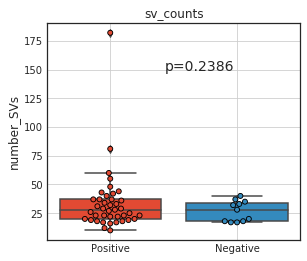

In [94]:
group_col = 'HIV_status'
value_cols = ['sv_counts']
titles = value_cols
df = ndf.copy()
# gene = 'SF3B1'
# boxplot overlaps individual data point
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(10,4))

    gs = gridspec.GridSpec(int(len(value_cols)/3.0)+1, 2)
    group_col = 'HIV_status'
    categories = sorted(df[group_col].unique().tolist(), reverse=True) 
    p_values = {}
    for k, col in enumerate(value_cols):
#         print(k, col)
        ax = fig.add_subplot(gs[k])
#         _ = ax.set_yscale("log")
        value_col = col
        _ = sns.swarmplot(x=group_col, y=col, data=df, edgecolor="black", linewidth=.9)
        _ = sns.boxplot(x=group_col, y=col, data=df, saturation=1, ax=ax)

        grps = {}
        # overlay actuall data point
        for i, cat in enumerate(categories):
            grps[i] = df.query('{0} == "{1}"'.format(group_col, cat))[col]

        
        # statistical test for 1st grp
        sts, p = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
        p = round(p, 4)
        _ = ax.text(0.6, 0.80,'p={}'.format(p), ha='center', va='center', transform=ax.transAxes, size=14) 
#         ax.tick_params(axis='x', labelsize=18) #specify x tick label size
#         _ = ax.set_xticks(range(position+1))
#         _ = ax.set_xticklabels(categories, rotation=0)
        _ = ax.set_title('{}'.format(titles[k]), fontsize=12)
#         _ = ax.set_xlim(xmin=-0.5)
#         _= ax.set_ylabel('spicing events', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('number_SVs')
        ax.grid(True)

    plt.suptitle('', fontsize=14)       
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/fusion/124_patients/sv_difference.png'
    plt.savefig(of, dpi=200, box_inches='tight')
plt.show()
plt.close()